# Task-based EEG Correlates of Sustained Attention in Ageing - Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
from scipy import stats
import pingouin as pg
import statsmodels.api as sm 
import os

# Set current working and data dir
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')

# Load the Excel files into DataFrames and set the first column as the index
df_demo = pd.read_excel(os.path.join(data_dir, 'LEISURE_T1_SART_EEG_demographics.xlsx')).dropna(subset='Subject')
df_cog = pd.read_excel(os.path.join(data_dir, 'LEISURE_T1_SART_T1_task_performance.xlsx')).dropna(subset='Subject')
df_eeg = pd.read_excel(os.path.join(data_dir, 'LEISURE_T1_SART_EEG_spectral_prepost.xlsx')).dropna(subset='Subject')

# Merge three dfs together
df_demo_cog = pd.merge(df_demo, df_cog, how='inner', on='Subject')
df = pd.merge(df_demo_cog, df_eeg, how='inner', on='Subject').reset_index(drop=True)

# Drop IDs
#ids_to_drop = ['HBA_0003_SART_T1', 'HBA_0011_SART_T1', 'HBA_0016_SART_T1', 'HBA_0026_SART_T1', 
#               'HBA_0006_SART_T1', 'HBA_0007_SART_T1', 'HBA_0014_SART_T1', 'HBA_0016_SART_T1', 'HBA_0070_SART_T1', 'HBA_0098_SART_T1', 'HBA_0108_SART_T1', 'HBA_0115_SART_T1', 'HBA_0119_SART_T1']
#df = df[~df['Subject'].isin(ids_to_drop)]

## Calculate RTCV and aperiodic shift

In [3]:
# RTCV coefficient variability (correct GO)
df['RTCV (Correct GO)'] = df['SD RT (Correct GO)'] / df['Average RT (Correct GO)']

# Aperiodic activity shift from pre-stimulus to post-stimulus for each condition
df['GO shift Exponent'] = df['Mean post minus ERP GO Exponent'] - df['Mean pre GO Exponent']
df['NO-GO shift Exponent'] = df['Mean post minus ERP NO-GO Exponent'] - df['Mean pre NO-GO Exponent']
df['GO shift Offset'] = df['Mean post minus ERP GO Offset'] - df['Mean pre GO Offset']
df['NO-GO shift Offset'] = df['Mean post minus ERP NO-GO Offset'] - df['Mean pre NO-GO Offset']

## Outlier identification and adjustment

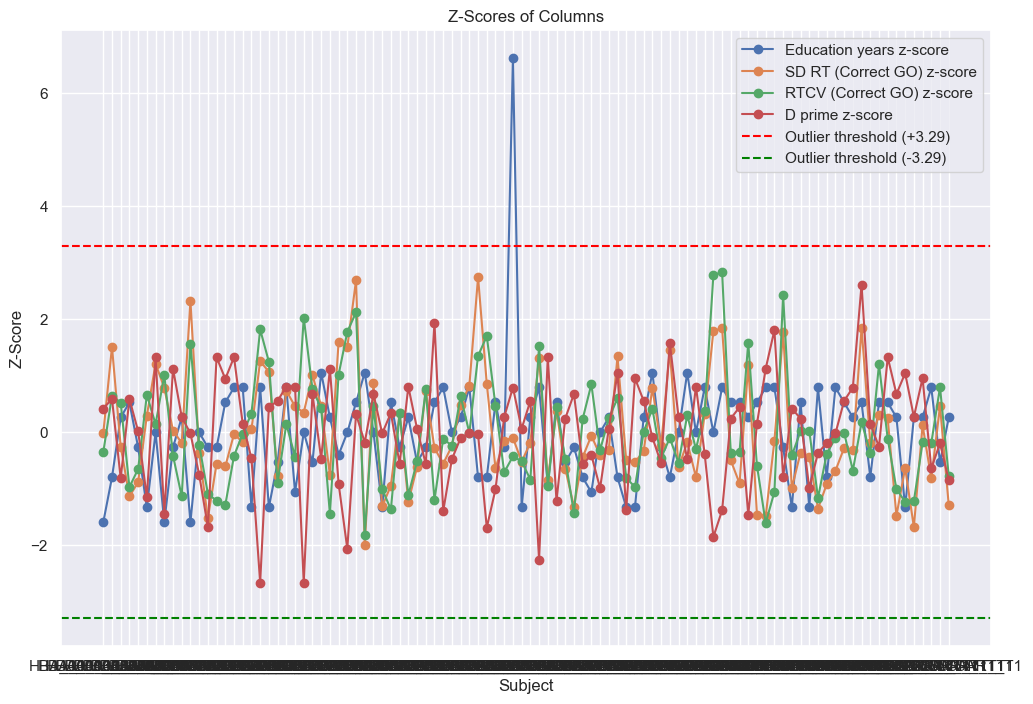

Outliers found:
Subject: HBA_0062_SART_T1, Column: Education years, Value: 40.0, Z-Score: 6.62


In [4]:
columns_to_check = ['Education years', 'SD RT (Correct GO)', 'RTCV (Correct GO)', 'D prime']
# Plotting z-scores for visualization
plt.figure(figsize=(12, 8))
for col in columns_to_check:
    # Calculate z-scores on the fly
    zs = stats.zscore(df[col])
    plt.plot(df['Subject'], zs, marker='o', linestyle='-', label=f'{col} z-score')
plt.axhline(3.29, color='red', linestyle='--', label='Outlier threshold (+3.29)')
plt.axhline(-3.29, color='green', linestyle='--', label='Outlier threshold (-3.29)')
plt.xlabel('Subject')
plt.ylabel('Z-Score')
plt.title('Z-Scores of Columns')
plt.legend()
plt.show()

# Identify outliers and the associated subject and column
outliers = []
for col in columns_to_check:
    zs = stats.zscore(df[col])
    for idx in df.index:
        if zs[idx] > 3.29 or zs[idx] < -3.29:
            outliers.append((df.loc[idx, 'Subject'], col, df.loc[idx, col], zs[idx]))

# Print outlier information
print("Outliers found:")
for outlier in outliers:
    print(f"Subject: {outlier[0]}, Column: {outlier[1]}, Value: {outlier[2]}, Z-Score: {outlier[3]:.2f}")

In [5]:
# Define the threshold for z-scores
z_score_threshold = 3.29

# Function to calculate z-score threshold values
def calc_thresholds(series):
    mean_val = series.mean()
    std_val = series.std()
    max_threshold = mean_val + (z_score_threshold * std_val)
    min_threshold = mean_val - (z_score_threshold * std_val)
    return min_threshold, max_threshold

# Function to check for outliers and adjust if necessary
def adjust_outliers(series, min_threshold, max_threshold):
    adjusted_series = series.copy()
    outliers_exist = False
    for i, value in enumerate(series):
        if value > max_threshold:
            adjusted_series.iloc[i] = max_threshold - 1
            outliers_exist = True
        elif value < min_threshold:
            adjusted_series.iloc[i] = min_threshold + 1
            outliers_exist = True
    return adjusted_series if outliers_exist else None

# Adjust and create new columns if there are outliers
for col in columns_to_check:
    # Calculate the min and max threshold values for actual data
    min_threshold, max_threshold = calc_thresholds(df[col])
    
    # Adjust the values based on thresholds, if outliers exist
    adjusted_series = adjust_outliers(df[col], min_threshold, max_threshold)
    if adjusted_series is not None:
        df[f'{col} OA'] = adjusted_series

In [5]:
df

,Subject,Age,Gender (F),Education years,Total GO,Total NO-GO,Correct GO,Correct NO-GO,Incorrect GO,Incorrect NO-GO,...,Mean post minus ERP NO-GO Exponent,Mean post minus ERP NO-GO Offset,Mean post minus ERP NO-GO R_2,Mean post minus ERP NO-GO Error,RTCV (Correct GO),GO shift Exponent,NO-GO shift Exponent,GO shift Offset,NO-GO shift Offset,Education years OA
0,HBA_0001_SART_T1,79.227926,1,9.0,480,60,479,55,1,5,...,0.655463,0.432310,0.898154,0.054190,0.211512,0.166711,0.165796,0.128920,0.108652,9.0
2,HBA_0004_SART_T1,74.373038,1,16.0,480,60,480,35,0,25,...,0.604367,0.505373,0.915193,0.051550,0.253566,0.232018,0.161795,0.224024,0.173009,16.0
3,HBA_0005_SART_T1,51.096509,1,17.0,480,60,479,56,1,4,...,1.048182,0.537452,0.971326,0.048845,0.181961,0.142357,0.130855,0.249995,0.202856,17.0
6,HBA_0009_SART_T1,79.498973,0,15.0,480,60,480,57,0,3,...,0.796727,0.344537,0.936499,0.055300,0.235395,0.134941,0.228390,0.130360,0.238741,15.0
7,HBA_0010_SART_T1,74.173177,1,9.0,480,60,471,48,9,12,...,1.203484,0.731211,0.980932,0.032821,0.277089,0.414248,0.530050,0.451088,0.468286,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,HBA_0122_SART_T1,59.499641,1,16.0,480,60,479,54,1,6,...,1.029410,0.494366,0.974434,0.040979,0.169963,0.222468,0.285144,0.236563,0.329287,16.0
94,HBA_0126_SART_T1,55.343580,1,16.0,480,60,480,55,0,5,...,0.985214,0.753117,0.990549,0.024327,0.219891,0.226922,0.323413,0.224269,0.308121,16.0
95,HBA_0128_SART_T1,62.184805,1,18.0,480,60,479,45,1,15,...,0.516198,0.098420,0.802333,0.073769,0.219361,0.126002,0.249070,0.142575,0.258587,18.0
96,HBA_0129_SART_T1,74.442163,1,13.0,480,60,479,50,1,10,...,1.033893,0.852722,0.983476,0.040861,0.266852,0.154972,0.357803,0.160144,0.307964,13.0


## Normality testing

### Shapiro-Wilks

In [6]:
# List of columns you want to test
columns_to_test = ['SD RT (Correct GO)', 'RTCV (Correct GO)', 'D prime']

# Dictionary to hold the results
shapiro_wilks = {}

# Perform the normality test for each specified column
for col in columns_to_test:
    # The normality test is run on each column individually and the result is stored
    shapiro_wilks[col] = pg.normality(data=df[col])

# To display the results for each column
for col, result in shapiro_wilks.items():
    print(f"Results for {col}:")
    display(result)

Results for SD RT (Correct GO):


,W,pval,normal
SD RT (Correct GO),0.963843,0.013244,False


Results for RTCV (Correct GO):


,W,pval,normal
RTCV (Correct GO),0.962839,0.011323,False


Results for D prime:


,W,pval,normal
D prime,0.988604,0.628361,True


### Histograms

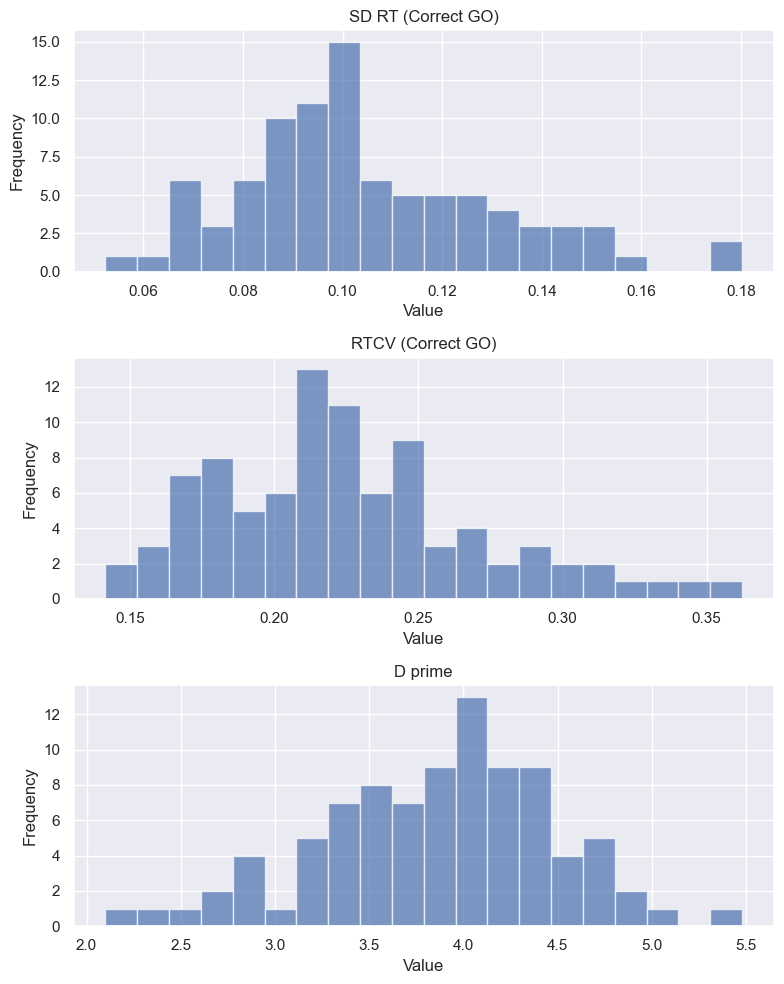

In [7]:
# Setup the figure and axes
fig, axs = plt.subplots(len(columns_to_test), figsize=(8, 10), tight_layout=True)

# Iterate over the columns and create a histogram for each
for ax, column in zip(axs, columns_to_test):
    ax.hist(df[column], bins=20, alpha=0.7, label=column)
    ax.set_title(f'{column}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()

In [32]:
EEGcols_hist = ['Mean pre GO Exponent', 'Mean pre GO Offset', 'Mean pre NO-GO Exponent', 'Mean pre NO-GO Offset', 'Mean post minus ERP GO Exponent', 'Mean post minus ERP GO Offset', 'Mean post minus ERP NO-GO Exponent', 'Mean post minus ERP NO-GO Offset', 'GO shift Exponent', 'NO-GO shift Exponent']

### Q-Q plots

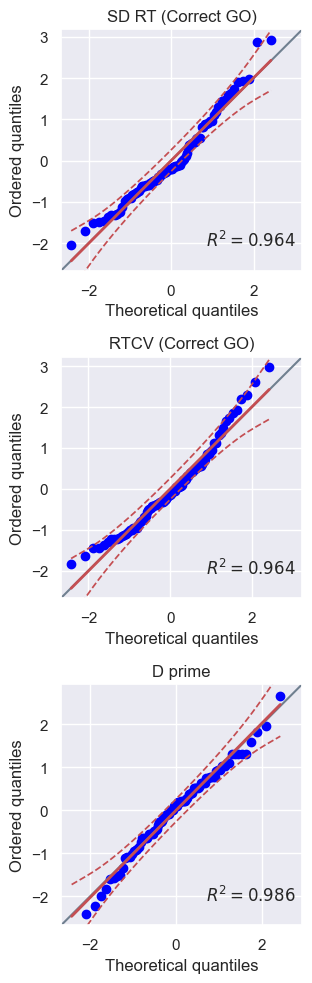

In [8]:
fig, axs = plt.subplots(len(columns_to_test), figsize=(8, 10), tight_layout=True)

# Make sure axs is an array even if there's only one plot
if len(columns_to_test) == 1:
    axs = [axs]

# Iterate over the columns and create a Q-Q plot for each
for ax, column in zip(axs, columns_to_test):
    pg.qqplot(df[column], dist='norm', ax=ax)
    ax.set_title(f'{column}')

plt.show()

## Describe data

In [6]:
# Counting the number of females in the dataset
number_of_females = df['Gender (F)'].sum()

# Display the count
print("Number of females in the sample:", number_of_females)

Number of females in the sample: 69


In [7]:
df.describe()

,Age,Gender (F),Education years,Total GO,Total NO-GO,Correct GO,Correct NO-GO,Incorrect GO,Incorrect NO-GO,Average RT (Correct GO),...,Mean post minus ERP NO-GO Exponent,Mean post minus ERP NO-GO Offset,Mean post minus ERP NO-GO R_2,Mean post minus ERP NO-GO Error,RTCV (Correct GO),GO shift Exponent,NO-GO shift Exponent,GO shift Offset,NO-GO shift Offset,Education years OA
count,86.000000,86.000000,86.000000,86.0,86.0,86.000000,86.000000,86.000000,86.000000,86.000000,...,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,64.851887,0.802326,15.116279,480.0,60.0,478.290698,50.058140,1.709302,9.941860,0.464876,...,0.919401,0.506078,0.947357,0.050308,0.226388,0.239913,0.279928,0.247128,0.274039,14.964358
std,8.287287,0.400581,3.896208,0.0,0.0,2.848596,6.399181,2.848596,6.399181,0.069373,...,0.216472,0.252006,0.050174,0.015804,0.046788,0.104100,0.120767,0.142170,0.133950,3.084745
min,50.162229,0.000000,9.000000,480.0,60.0,468.000000,32.000000,0.000000,0.000000,0.334981,...,0.355459,-0.201926,0.715215,0.024327,0.141416,0.069119,-0.039838,0.050196,-0.045493,9.000000
25%,59.290212,1.000000,13.000000,480.0,60.0,478.000000,46.250000,0.000000,5.000000,0.412979,...,0.774818,0.383704,0.935828,0.036724,0.190353,0.171752,0.203707,0.160048,0.186447,13.000000
50%,64.384353,1.000000,15.500000,480.0,60.0,479.000000,51.000000,1.000000,9.000000,0.457922,...,0.956191,0.493524,0.966766,0.048184,0.219626,0.228046,0.302031,0.219566,0.277163,15.500000
75%,71.186858,1.000000,17.000000,480.0,60.0,480.000000,55.000000,2.000000,13.750000,0.506030,...,1.037510,0.648442,0.978299,0.059873,0.250642,0.270571,0.355557,0.291404,0.349558,17.000000
max,84.036269,1.000000,40.000000,480.0,60.0,480.000000,60.000000,12.000000,28.000000,0.657536,...,1.441549,1.124399,0.990804,0.084782,0.362286,0.710181,0.530050,1.020547,0.563907,26.934804


## Correlations

In [6]:
# Define column lists of interest
demo_cols = ['Age', 'Gender (F)', 'Education years OA']
cog_total_cols = ['Correct GO','Correct NO-GO', 'Incorrect GO', 'Incorrect NO-GO']
cog_RTs_cols = ['Average RT (Correct GO)', 'SD RT (Correct GO)', 'RTCV (Correct GO)', 'Average RT (Incorrect NO-GO)', 'SD RT (Incorrect NO-GO)', 'Median RT (Correct GO)']
cog_sdt_cols = ['Hit rate', 'False Alarm rate', 'Adjusted Hit rate', 'Adjusted False Alarm rate', 'z - Hit rate', 'z - False Alarm rate', 'D prime', 'Criterion']
eeg_pre_GO = ['Mean pre GO Exponent', 'Mean pre GO Offset']
eeg_pre_NOGO = ['Mean pre NO-GO Exponent', 'Mean pre NO-GO Offset']
eeg_post_GO = ['Mean post minus ERP GO Exponent', 'Mean post minus ERP GO Offset']
eeg_post_NOGO = ['Mean post minus ERP NO-GO Exponent', 'Mean post minus ERP NO-GO Offset']
eeg_exponent_shift = ['GO shift Exponent', 'NO-GO shift Exponent']
eeg_offset_shift = ['GO shift Offset', 'NO-GO shift Offset']

### Pearson partial

In [7]:
# Define x variable, list of y variables, and covariates
x_variable = 'Age'
y_variables = ['Average RT (Correct GO)', 'SD RT (Correct GO)', 'RTCV (Correct GO)', 'D prime', 'False Alarm rate', 'Mean pre GO Exponent', 'Mean pre GO Offset', 
               'Mean pre NO-GO Exponent', 'Mean pre NO-GO Offset', 'Mean post minus ERP GO Exponent', 'Mean post minus ERP GO Offset', 'Mean post minus ERP NO-GO Exponent', 'Mean post minus ERP NO-GO Offset', 'GO shift Exponent', 'NO-GO shift Exponent']
covariates = ['Gender (F)', 'Education years OA']

# Prepare a list to hold each row of the new DataFrame
rows = []

# Loop through each y variable and compute the partial correlation
for y_variable in y_variables:
    result = pg.partial_corr(data=df, x=x_variable, y=y_variable, covar=covariates)
    # Extract the necessary values from the result and add to the rows list
    row = {
        'Y Variable': y_variable,
        'n': result['n'].values[0],
        'r': result['r'].values[0],
        'p-val': result['p-val'].values[0]
    }
    rows.append(row)

# Create a new DataFrame from the rows list
partial_corr_df = pd.DataFrame(rows)

# Display the new DataFrame
display(partial_corr_df)

,Y Variable,n,r,p-val
0,Average RT (Correct GO),98,0.148747,0.148069
1,SD RT (Correct GO),98,0.263453,0.009501
2,RTCV (Correct GO),98,0.209704,0.040304
3,D prime,98,-0.218867,0.032161
4,False Alarm rate,98,0.172497,0.092840
5,Mean pre GO Exponent,98,-0.177043,0.084421
6,Mean pre GO Offset,98,-0.083543,0.418374
7,Mean pre NO-GO Exponent,98,-0.233929,0.021795
8,Mean pre NO-GO Offset,98,-0.130041,0.206655
9,Mean post minus ERP GO Exponent,98,-0.202081,0.048329


### Spearman partial

In [24]:
# Define x variable, list of y variables, and covariates
x_variable = 'Age'
y_variables = ['Average RT (Correct GO)', 'SD RT (Correct GO)', 'RTCV (Correct GO)', 'D prime', 'Mean pre GO Exponent', 'Mean pre GO Offset', 
               'Mean pre NO-GO Exponent', 'Mean pre NO-GO Offset', 'Mean post minus ERP GO Exponent', 'Mean post minus ERP GO Offset', 'Mean post minus ERP NO-GO Exponent', 'Mean post minus ERP NO-GO Offset', 'GO shift Exponent', 'GO shift Offset', 'NO-GO shift Exponent']
covariates = ['Gender (F)', 'Education years OA']

# Prepare a list to hold each row of the new DataFrame
rows = []

# Loop through each y variable and compute the partial correlation
for y_variable in y_variables:
    result = pg.partial_corr(data=df, x=x_variable, y=y_variable, covar=covariates, method='spearman')
    # Extract the necessary values from the result and add to the rows list
    row = {
        'Y Variable': y_variable,
        'n': result['n'].values[0],
        'r': result['r'].values[0],
        'p-val': result['p-val'].values[0]
    }
    rows.append(row)

# Create a new DataFrame from the rows list
partial_corr_df = pd.DataFrame(rows)

# Display the new DataFrame
display(partial_corr_df)

,Y Variable,n,r,p-val
0,Average RT (Correct GO),86,0.165655,0.132085
1,SD RT (Correct GO),86,0.318248,0.003176
2,RTCV (Correct GO),86,0.258952,0.017383
3,D prime,86,-0.341584,0.001473
4,Mean pre GO Exponent,86,-0.216309,0.048125
5,Mean pre GO Offset,86,-0.100650,0.362315
6,Mean pre NO-GO Exponent,86,-0.258234,0.017708
7,Mean pre NO-GO Offset,86,-0.123664,0.262404
8,Mean post minus ERP GO Exponent,86,-0.252084,0.020708
9,Mean post minus ERP GO Offset,86,-0.149247,0.175424


In [23]:
# HLRs
import warnings
from HLR import HierarchicalLinearRegression
warnings.simplefilter(action='ignore', category=FutureWarning)

X = {
    1: ['Age', 'Gender (F)', 'Education years OA'],
    2: ['Age', 'Gender (F)', 'Education years OA', 'GO shift Offset']
}
y = 'D prime'

model = HierarchicalLinearRegression(df, X, y)
model.summary()
# model.diagnostics()

# model.summary().to_excel("results/test.xlsx", index=False)

,Model Level,Predictors,N (observations),DF (residuals),DF (model),R-squared,F-value,P-value (F),SSR,SSTO,...,MSE (total),Beta coefs,P-values (beta coefs),Std Beta coefs,Partial correlations,Semi-partial correlations,Unique variance %,R-squared change,F-value change,P-value (F-value change)
0,1,"[Age, Gender (F), Education years OA]",86.0,82.0,3.0,0.098635,2.991049,0.035646,29.770840,33.028622,...,0.388572,"{'const': 5.080710193135232, 'Age': -0.0220964...","{'const': 6.836620465956728e-11, 'Age': 0.0072...","{'Age': -0.29376470955828704, 'Gender (F)': 0....","{'Age': -0.2908419717821655, 'Gender (F)': 0.1...","{'Age': -0.2886020087738258, 'Gender (F)': 0.1...","{'Age': 8.329111946828743, 'Gender (F)': 1.224...",NaN,NaN,NaN
1,2,"[Age, Gender (F), Education years OA, GO shift...",86.0,81.0,4.0,0.143395,3.389842,0.012900,28.292473,33.028622,...,0.388572,"{'const': 5.4691476190046275, 'Age': -0.024363...","{'const': 1.1016391743895537e-11, 'Age': 0.002...","{'Age': -0.32389762005565825, 'Gender (F)': 0....","{'Age': -0.32232012064885646, 'Gender (F)': 0....","{'Age': -0.315135297359202, 'Gender (F)': 0.11...","{'Age': 9.931025564167266, 'Gender (F)': 1.411...",0.04476,4.232494,0.042875
